In [20]:
from torchvision.datasets.utils import download_url
import json
# Download class labels from imagenet dataset
download_url("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", ".", "imagenet_class_index.json")

with open("imagenet_class_index.json", "r") as h:
    labels = json.load(h)

Using downloaded and verified file: ./imagenet_class_index.json


In [21]:
import torch
from torch.utils import data
from torchvision.models import alexnet
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np


transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# initialize the model
model = alexnet(pretrained=True)

# set the evaluation mode
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
# get the image from the dataloader
dataset = datasets.ImageFolder(root='./data/', transform=transform)
dataloader = data.DataLoader(dataset=dataset, shuffle=False )#batch_size=1
img, _ = next(iter(dataloader))

In [23]:
# get the most likely prediction of the model
pred = model(img)#.argmax(dim=1)
pred_sorted = torch.sort(pred, descending=False)

In [24]:
import re
print(pred.argmax(dim=1))
with open("imagenet_class_index.json", "r") as h:
    labels = json.load(h)

str_label = str(pred.argmax(dim=1))
str_label = re.findall(r'\d+', str_label)
print(labels[str_label[0]])

tensor([2])
['n01484850', 'great_white_shark']


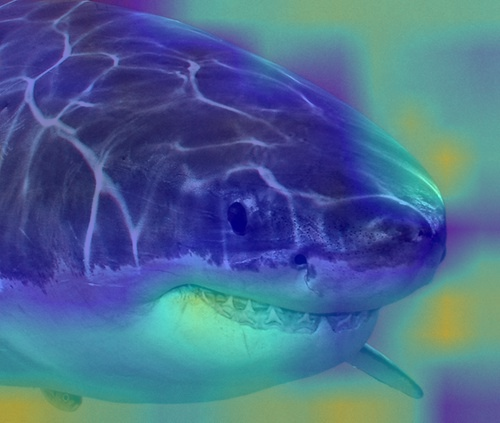

In [25]:
from pytorch_grad_cam import GradCAM
import cv2
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
img = np.asarray(cv2.imread('./data/Shark/shark.jpg'))

img = np.squeeze(img)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = np.float32(img)/255
input_tensor = preprocess_image(img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
target_layers = [model.features[-1]]

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False) # use_cuda=args.use_cuda

grayscale_cam = cam(input_tensor=input_tensor, targets=None, aug_smooth=True, eigen_smooth=True )[0, :]

visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True, colormap = cv2.COLORMAP_JET) #

Image.fromarray(visualization)